## classifier method search

premise: use a looped grid search to explore the accuracy metrics of classfiers

In [ ]:
!pip3 install shap

In [25]:
import category_encoders as ce
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, RandomTreesEmbedding, BaggingClassifier
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from scipy import stats

from sklearn.tree import DecisionTreeClassifier
import shap
import pandas as pd

In [2]:
m2_pipeline = pd.read_csv('binned_pipeline.csv')


## testing data for colinearity among features

In [3]:
m2_pipeline.corr(numeric_only=True)

,Unnamed: 0,precursor_buy_cap_pct_change,precursor_ask_cap_pct_change,precursor_bid_vol_pct_change,precursor_ask_vol_pct_change,sum_change,length,surge_targets_met_pct,label
Unnamed: 0,1.000000,-0.072097,-0.044220,-0.079542,-0.002249,0.027246,0.061405,0.009566,-0.019687
precursor_buy_cap_pct_change,-0.072097,1.000000,0.176897,0.829986,0.178041,0.123180,-0.064895,0.047555,0.031515
precursor_ask_cap_pct_change,-0.044220,0.176897,1.000000,0.284965,0.214040,-0.131156,0.028824,0.092484,0.025729
precursor_bid_vol_pct_change,-0.079542,0.829986,0.284965,1.000000,0.092731,0.014314,-0.003254,0.044184,0.024714
precursor_ask_vol_pct_change,-0.002249,0.178041,0.214040,0.092731,1.000000,-0.018833,-0.004819,-0.004618,-0.004898
sum_change,0.027246,0.123180,-0.131156,0.014314,-0.018833,1.000000,-0.247413,-0.094531,-0.081770
length,0.061405,-0.064895,0.028824,-0.003254,-0.004819,-0.247413,1.000000,0.044550,0.024845
surge_targets_met_pct,0.009566,0.047555,0.092484,0.044184,-0.004618,-0.094531,0.044550,1.000000,0.878781
label,-0.019687,0.031515,0.025729,0.024714,-0.004898,-0.081770,0.024845,0.878781,1.000000


<Axes: >

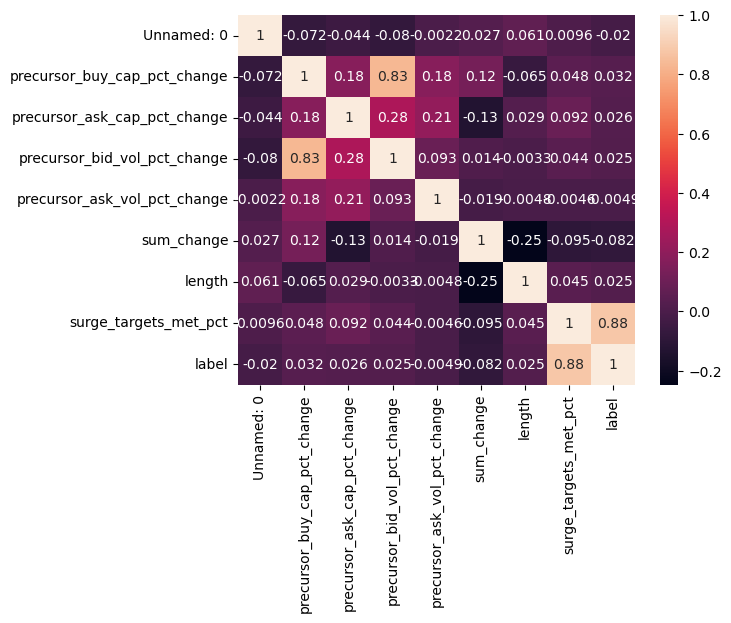

In [4]:
import pandas as pd
import seaborn as sns

# Load the dataset into a pandas dataframe

# Calculate the correlation matrix
corr_matrix = m2_pipeline.corr(numeric_only=True)

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True)


XGB, GBM, CAT, FASTAI, NN_TORCH, LR, RF, XT

In [5]:
m2_pipeline.dtypes

Unnamed: 0                        int64
precursor_buy_cap_pct_change    float64
precursor_ask_cap_pct_change    float64
precursor_bid_vol_pct_change    float64
precursor_ask_vol_pct_change    float64
sum_change                      float64
length                            int64
surge_targets_met_pct           float64
label                             int64
dtype: object

### utilize the same feature composition as used in step 2

clustering setup, per 'step 2'

set m2_pipeline features to the set, below to do a classifier search

In [6]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length']

In [35]:

# Splitting the dataframe into features and labels
# X = m2_pipeline.drop(columns=['label'])
y = m2_pipeline['label']
X = m2_pipeline[keepable]
# Performing the test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Define the classifiers and their respective hyperparameters
classifiers = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    # ce.CatBoostEncoder(),
    # RandomTreesEmbedding(),
    RidgeCV(),
    LassoCV(),
    # SVC()
]

params = {
    'RandomForestClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'GradientBoostingClassifier': {'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'HistGradientBoostingClassifier': {'learning_rate': [0.1, 0.01], 'max_iter': [100, 200]},
    'ExtraTreesClassifier':{'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    # 'RandomTreesEmbedding':{'n_estimators': [10, 100, 1000], 'max_depth': [None, 10, 100]},
    'BaggingClassifier':{ 'n_estimators':[10],  'random_state':[42]},
    # 'CatBoostEncoder':{'cols':['label'], 'drop_invariant':False, 'return_df':False, 'random_state':[42]},
    'RidgeCV':{'alphas':[0.1, 1.0, 10.0]},
    'LassoCV':{ 'eps':[0.001, 0.01, .1], 'n_alphas':[100,200],  'max_iter':[100,200,300,1000]},
    # 'SVC':{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
}
comparative = []
# Perform the grid search
for clf in classifiers:
    name = clf.__class__.__name__
    if name in params:
        grid_search = GridSearchCV(clf, params[name], cv=5)
        grid_search.fit(X_train_scaled, y_train)
        print(f"Best parameters for {name}: {grid_search.best_params_}")
        accuracy = grid_search.score(X_test, y_test)
        dict = {"classifier":name, "best_params":grid_search.best_params_, "accuracy":accuracy}
        comparative.append(dict)
dg = pd.DataFrame(comparative) #display grid

Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100}


X has feature names, but RandomForestClassifier was fitted without feature names


Best parameters for GradientBoostingClassifier: {'max_depth': 10, 'n_estimators': 10}


X has feature names, but GradientBoostingClassifier was fitted without feature names


Best parameters for HistGradientBoostingClassifier: {'learning_rate': 0.01, 'max_iter': 100}


X has feature names, but HistGradientBoostingClassifier was fitted without feature names


Best parameters for ExtraTreesClassifier: {'max_depth': 10, 'n_estimators': 1000}


X has feature names, but ExtraTreesClassifier was fitted without feature names


Best parameters for BaggingClassifier: {'n_estimators': 10, 'random_state': 42}
Best parameters for RidgeCV: {'alphas': 10.0}


X has feature names, but BaggingClassifier was fitted without feature names
X has feature names, but RidgeCV was fitted without feature names


Best parameters for LassoCV: {'eps': 0.1, 'max_iter': 100, 'n_alphas': 200}


X has feature names, but LassoCV was fitted without feature names


In [36]:
dg

,classifier,best_params,accuracy
0,RandomForestClassifier,"{'max_depth': 10, 'n_estimators': 100}",0.436535
1,GradientBoostingClassifier,"{'max_depth': 10, 'n_estimators': 10}",0.401372
2,HistGradientBoostingClassifier,"{'learning_rate': 0.01, 'max_iter': 100}",0.433962
3,ExtraTreesClassifier,"{'max_depth': 10, 'n_estimators': 1000}",0.428816
4,BaggingClassifier,"{'n_estimators': 10, 'random_state': 42}",0.411664
5,RidgeCV,{'alphas': 10.0},-0.080472
6,LassoCV,"{'eps': 0.1, 'max_iter': 100, 'n_alphas': 200}",-0.022408


In [7]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=100,random_state= 42)
gbc = GradientBoostingClassifier(max_depth= 10, n_estimators= 10,random_state= 42)
hgbc = HistGradientBoostingClassifier(learning_rate= 0.01, max_iter= 100,random_state= 42)
etc = ExtraTreesClassifier(max_depth= 10, n_estimators= 1000,random_state= 42)
bc = BaggingClassifier(n_estimators= 10, random_state= 42)


## Voting Classifier

In [8]:
import shap #this library would take 30 hours to explain the above model, not to be used. would function on one tree, better
from sklearn.ensemble import  VotingClassifier 
from sklearn.model_selection import cross_val_score
X = m2_pipeline.drop(columns=['label'])
y = m2_pipeline['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#normalize all numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Define VotingClassifier 
vc = VotingClassifier(estimators=[('rfc',rfc),('gbc',gbc),('hgbc',hgbc),('etc',etc),('bc',bc)], voting='soft') 
rfc.fit(X_train_scaled,y_train)
gbc.fit(X_train_scaled,y_train)
hgbc.fit(X_train_scaled,y_train)
etc.fit(X_train_scaled,y_train)
bc.fit(X_train_scaled,y_train)
# rvc.fit(X_train,y_train)
# lvc.fit(X_train,y_train)
vc.fit(X_train_scaled,y_train)
# runnable = [('rfc',rfc),('gbc',gbc),('hgbc',hgbc),('etc',etc),('bc',bc),('rvc',rvc),('lvc',lvc),('ensemble', vc)]
# #fit all
for clf, label in zip([rfc,gbc,hgbc,etc,bc,vc], ['RandomForestClassifier', 'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'ExtraTreesClassifier',\
                                                    'BaggingClassifier','Voting']):
    scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
# explainer = shap.KernelExplainer(vc.predict_proba, X_train) # Define explainer
# shap_values = explainer.shap_values(X_test) # Compute SHAP values for test set 
# shap.summary_plot(shap_values[1], X_test) # Plot summary plot of SHAP values for each feature 

Accuracy: 0.95 (+/- 0.00) [RandomForestClassifier]
Accuracy: 1.00 (+/- 0.00) [GradientBoostingClassifier]
Accuracy: 0.99 (+/- 0.00) [HistGradientBoostingClassifier]
Accuracy: 0.44 (+/- 0.00) [ExtraTreesClassifier]
Accuracy: 1.00 (+/- 0.00) [BaggingClassifier]
Accuracy: 1.00 (+/- 0.00) [Voting]


## Error Analysis

confusion matrix for multiclass predict vs true results. [source](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html)

In [16]:
labels_ = m2_pipeline['label'].unique()
print(labels_)

[ 4  5  6  7  3  2  9 10  1  8 11]


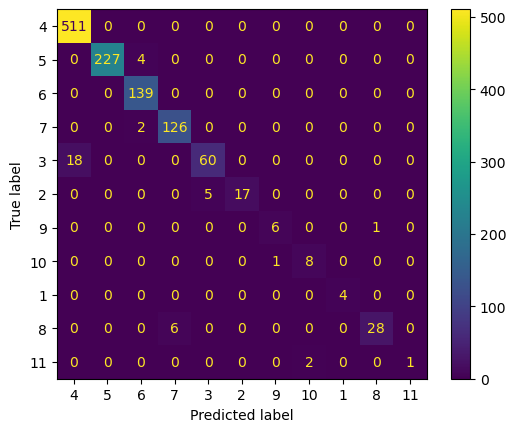

In [22]:
X_test_scaled = scaler.fit_transform(X_test)
y_pred = vc.predict(X_test_scaled)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=labels_)

error report courtesty of sklearn's [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn-metrics-classification-report)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      0.77      0.87        22
           3       0.92      0.77      0.84        78
           4       0.97      1.00      0.98       511
           5       1.00      0.98      0.99       231
           6       0.96      1.00      0.98       139
           7       0.95      0.98      0.97       128
           8       0.97      0.82      0.89        34
           9       0.86      0.86      0.86         7
          10       0.80      0.89      0.84         9
          11       1.00      0.33      0.50         3

    accuracy                           0.97      1166
   macro avg       0.95      0.86      0.88      1166
weighted avg       0.97      0.97      0.97      1166



uncertainty in prediction, per class basis, [per sklearn](https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits.html#plot-the-most-uncertain-predictions)

## SHAP feature analysis

[source](https://github.com/shap/shap)

In [ ]:
keepable = ['precursor_buy_cap_pct_change', 
            'precursor_ask_cap_pct_change',
            'precursor_bid_vol_pct_change', 
            'precursor_ask_vol_pct_change',
            'sum_change',
            'length']

### Random Forest Classifier Feature Strength

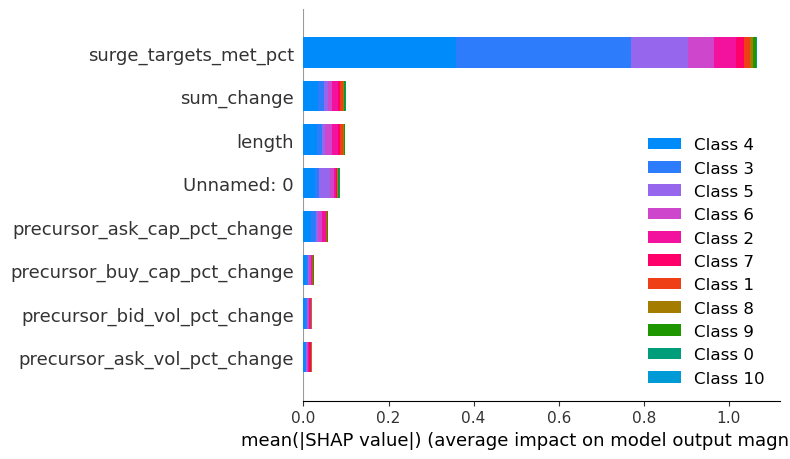

In [74]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = rfc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### HGBC SHAP

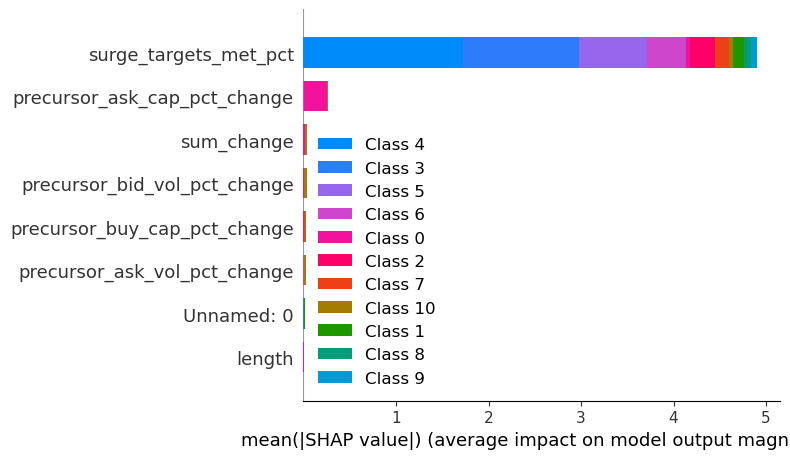

In [76]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = hgbc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

### Extra Trees Classifier SHAP

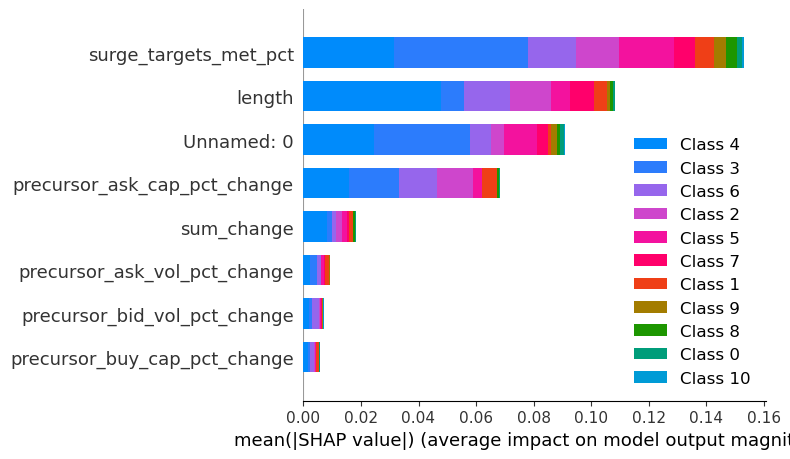

In [77]:
# estimators = [rfc,gbc,hgbc,etc,bc,vc]
model = etc.fit(X_train_scaled,y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, features=m2_pipeline.columns)

## 


### How do multiple classifiers collectively make good choices?

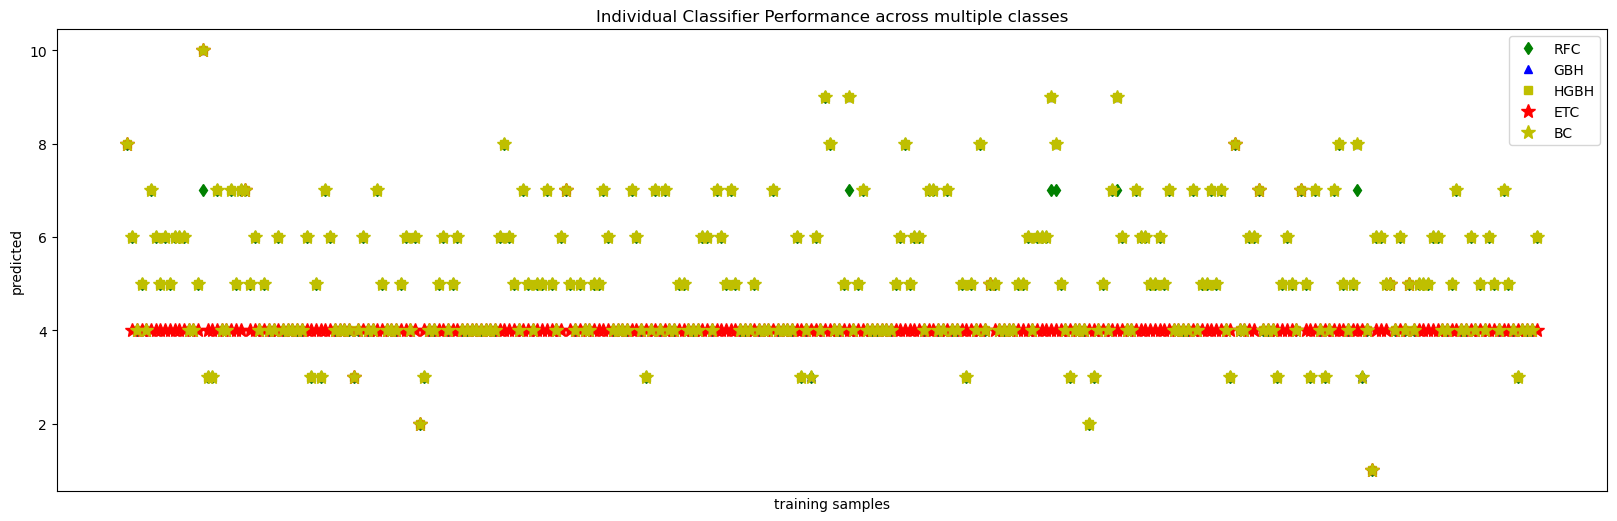

In [116]:
xt = X_train_scaled[:300]

pred1 = rfc.predict(xt)
pred2 = gbc.predict(xt)
pred3 = hgbc.predict(xt)

pred4 = etc.predict(xt)
pred5 = bc.predict(xt)
pred6 = vc.predict(xt)

plt.figure(figsize=(20,6))
plt.plot(pred1, "gd", label="RFC")
plt.plot(pred2, "b^", label="GBH")
plt.plot(pred3, "ys", label="HGBH")
plt.plot(pred4, "r*", ms=10, label="ETC")
plt.plot(pred5, "y*", ms=10, label="BC")
# plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Individual Classifier Performance across multiple classes")
ax.annotate('race interrupted', (61, 25),
            xytext=(0.8, 0.9), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
plt.show()


### Can the voting classifier locate optimal trades among a sea of lesser options?

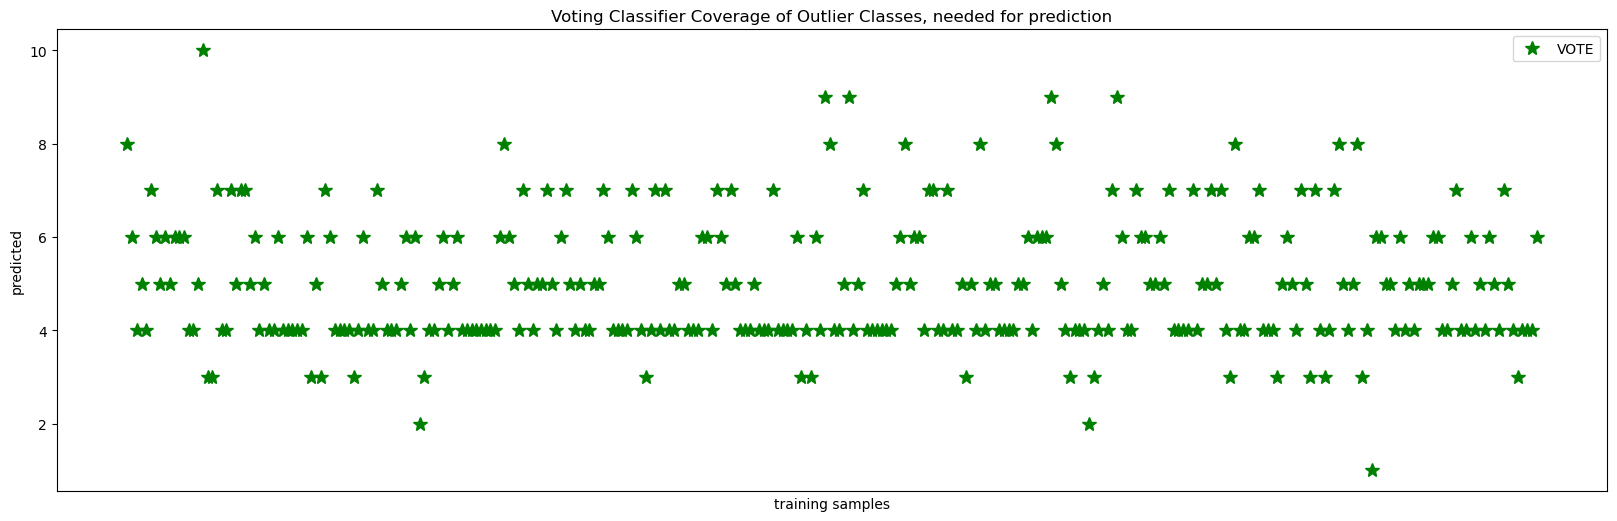

In [114]:
plt.figure(figsize=(20,6))
plt.plot(pred6, "g*", ms=10, label="VOTE")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Voting Classifier Coverage of Outlier Classes, needed for prediction")
plt.show()

## Permutation test scoring

[from sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html#permutation-test-score)

In [ ]:
#save this thing to .pkl format

# import pickle

# with open("model.pkl", "wb") as f:
#     pickle.dump(vc, f)